## Consumer Stocks - Dylan
Follow along the code to do the preliminary data analysis!\
**Please refer to the [meeting notes here](https://docs.google.com/document/d/1tnDnYfO5m5GQz5Fm7_TbpzHN9bG3RmvqpgvL4TyOevI/edit?usp=sharing) to get familiar with all the column names and the values associated with them.**

### Step 1: Install the necessary libraries for our data collection.
[yfinance](https://python-yahoofinance.readthedocs.io/en/latest/): used to fetch historical stock data (price, volume, etc.) from Yahoo Finance for our assigned sectors.\
[ta](https://technical-analysis-library-in-python.readthedocs.io/en/latest/): used to calculate technical indicators from the price data we get with yfinance. These indicators help our model understand:
- Trends (e.g., SMA, EMA, MACD)
- Momentum (e.g., RSI)
- Volatility (e.g., ATR, Bollinger Bands)
- Volume pressure (e.g., OBV)

In [4]:
!pip install yfinance
!pip install ta
!pip install fredapi

### Step 2: Import the necessary libraries

In [6]:
import yfinance as yf
import pandas as pd
import time
import ta
from fredapi import Fred
import pandas as pd
import os
from dotenv import load_dotenv
from fredapi import Fred

In [ ]:
# Data Handling
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings for nicer visuals
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

### Step 3: Collect Preliminary Stock Data Using `yfinance`

In this step, you will collect **5 years of historical daily stock data** for your assigned sector using the `yfinance` library.

**What this code does:**
- Loops through a list of stock tickers.
- Uses `yfinance` to download daily data for each stock over a 5-year period.
- Waits 3 seconds between requests to avoid hitting API limits.
- Cleans and formats the data: resets the index and adds a "Ticker" column.
- Stores all the data in one master DataFrame called `price_df`.

**What you need to do:**
- Replace the `tickers` list with the stocks **assigned to your sector**.
- You can find your list of stocks by referring to the excel file we created earlier [here](https://docs.google.com/spreadsheets/d/19n8ye_mwPM6QVbFJjG4eVUfiqUiGMQ-MujnMY_zMUs8/edit?usp=sharing).
- Run the code block to create your `price_df`, which you will later use for feature engineering.

If no data is found or an error occurs for a ticker, it will be skipped and reported in the output.\

*If you are running into errors with `yfinance` and hitting api limits, please wait a few hours and try running the code again. Please avoing running the cell multiple times to not run into this issue!*

Below is the code you should run (after customizing your ticker list):

In [8]:
# Refer back to the csv file to find the stocks you selected, and replace these tickers with your own.
tickers = [
    "DIS", "AMZN", "NKE", "SBUX", "LULU", "COST",
    "WMT", "MCD", "CMG", "BBY", "LYV", "EBAY",
    "EL", "LRLCY", "F", "RACE", "BUD",
    "NSRGY", "PEP", "KO"
]

#CODE BELOW DOES NOT NEED TO BE CHANGED
# List to hold all data
all_data = []

# Loop through each ticker
for ticker in tickers:
    try:
        df = yf.Ticker(ticker).history(period="5y", interval="1d")
        time.sleep(3) # wait in between requests to avoid request limits
        if df.empty:
            print(f"No data for {ticker}")
            continue

        df = df.reset_index()  # Convert index to Date column
        df["Ticker"] = ticker  # Add ticker column
        all_data.append(df[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]])
        print(f"{ticker} added")
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

# Concatenate all into one DataFrame
price_df = pd.concat(all_data, ignore_index=True)

# Preview the result
print(price_df.head())

DIS added
AMZN added
NKE added
SBUX added
LULU added
COST added
WMT added
MCD added
CMG added
BBY added
LYV added
EBAY added
EL added
LRLCY added
F added
RACE added
BUD added
NSRGY added
PEP added
KO added
                       Date Ticker        Open        High         Low  \
0 2020-04-20 00:00:00-04:00    DIS  102.316023  103.580402  100.755301   
1 2020-04-21 00:00:00-04:00    DIS   98.789594  100.271290   97.920328   
2 2020-04-22 00:00:00-04:00    DIS  100.557750  101.377616   99.658851   
3 2020-04-23 00:00:00-04:00    DIS   99.421782  101.278838   98.246301   
4 2020-04-24 00:00:00-04:00    DIS  100.537989  100.676280   98.305566   

        Close    Volume  
0  101.012131  17021000  
1   99.313126  16101400  
2   99.757629  11463800  
3   99.767509  17132200  
4   99.955193  13614100  


### Step 4: Generate Price-Based and Technical Indicators

Now that you have your stock data, it’s time to create additional features that help the model understand market trends, volatility, and momentum.

**What this code does:**
- Calculates **daily returns** and **VWAP** (volume-weighted average price).
- Adds several **technical indicators** like:
  - Simple and Exponential Moving Averages (SMA, EMA)
  - Relative Strength Index (RSI)
  - MACD and Signal Line
  - Bollinger Bands (Upper and Lower)
  - Average True Range (ATR)
  - On-Balance Volume (OBV)
- Groups the data by ticker to apply indicator calculations correctly.
- Combines everything into a single DataFrame with all features.

**What you need to do:**
- You **do not need to modify anything** in this code block **except one thing**:
  - In the **last line**, rename the CSV file to reflect your assigned sector name:
    ```python
    tech_df.to_csv("your_sector_name_data_with_indicators.csv", index=False)
    ```

Once this is done, you’ll have a feature-rich dataset ready for modeling!

In [10]:
tech_df = price_df.copy()

# --- Price-based indicators ---
tech_df['Daily Return'] = tech_df.groupby("Ticker")['Close'].pct_change(fill_method=None)
tech_df['Typical Price'] = (tech_df['High'] + tech_df['Low'] + tech_df['Close']) / 3
tech_df['VWAP'] = (tech_df['Typical Price'] * tech_df['Volume']).groupby(tech_df['Ticker']).cumsum() / tech_df['Volume'].groupby(tech_df['Ticker']).cumsum()

# --- Technical indicators ---
grouped = tech_df.groupby("Ticker", group_keys=False)
tech_df['SMA_20'] = grouped['Close'].apply(lambda x: x.rolling(window=20).mean())
tech_df['EMA_20'] = grouped['Close'].apply(lambda x: x.ewm(span=20, adjust=False).mean())
tech_df['RSI_14'] = grouped['Close'].apply(lambda x: ta.momentum.RSIIndicator(close=x, window=14).rsi())
tech_df['MACD'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd())
tech_df['MACD_Signal'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd_signal())
tech_df['BB_Upper'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_hband())
tech_df['BB_Lower'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_lband())
# Create empty columns
tech_df['ATR'] = None
tech_df['OBV'] = None

# Loop through each group (ticker) and calculate indicators
result_frames = []

for ticker, group in tech_df.groupby("Ticker"):
    group = group.copy()
    group.sort_values('Date', inplace=True)

    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['High'],
        low=group['Low'],
        close=group['Close']
    ).average_true_range()
    group['ATR'] = atr

    # OBV
    obv = ta.volume.OnBalanceVolumeIndicator(
        close=group['Close'],
        volume=group['Volume']
    ).on_balance_volume()
    group['OBV'] = obv

    result_frames.append(group)

# Combine the updated groups back together
tech_df = pd.concat(result_frames, ignore_index=True)

# Save to CSV, rename it to correspond to your sector. Please replace "sector" with your corresponding sector.
tech_df.to_csv("consumer_data_with_indicators.csv", index=False)

### Data Collection – Economic Data via FRED API
We're using the *FRED (Federal Reserve Economic Data) API* to pull U.S. macroeconomic indicators like GDP, unemployment rate, CPI, and more.

**Step 1: Create a .env File in the Root Directory**

- In the main folder of your project (same level as your notebook or script), create a file called: `.env`
- Inside the `.env` file, paste the following (replace `your_api_key_here` with your own key that you generate from step 2): `FRED_API_KEY=your_api_key_here`

**Step 2: Get Your API Key from FRED**
- Go to: https://fred.stlouisfed.org/
- Click Sign In (or Create an account if you don’t have one).
- Go to My Account > API Keys
- Click "Generate API Key"
- Copy the key and paste it into your .env file as shown above.

In [ ]:
from fredapi import Fred
import pandas as pd

load_dotenv()  # Load variables from .env
fred = Fred(api_key=os.getenv("FRED_API_KEY"))

# Define your date range
start_date = '2020-04-01'
end_date = '2025-04-01'

# Pull and align economic data to your date range
economic_data = pd.DataFrame({
    'Unemployment': fred.get_series('UNRATE', start_date, end_date),
    'Inflation_CPI': fred.get_series('CPIAUCSL', start_date, end_date),
    'Fed_Funds_Rate': fred.get_series('FEDFUNDS', start_date, end_date),
    'GDP': fred.get_series('GDP', start_date, end_date),
    '10Y_Treasury': fred.get_series('GS10', start_date, end_date),
    'Consumer_Sentiment': fred.get_series('UMCSENT', start_date, end_date),
    'Retail_Sales': fred.get_series('RSAFS', start_date, end_date),
})

# Set the date as the index (if it isn't already)
economic_data.index.name = 'Date'

# Preview the aligned economic data
economic_data.head()

## Exploratory Data Analysis (EDA)

Load the csv you just created, and give it a name. Replace the csv name (what is in quoets ""), with the csv you created above.

In [13]:
consumer_df = pd.read_csv("consumer_data_with_indicators.csv")
consumer_df.head() #shows first 5 rows of data frame

,Date,Ticker,Open,High,Low,Close,Volume,Daily Return,Typical Price,VWAP,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,BB_Upper,BB_Lower,ATR,OBV
0,2020-04-20 00:00:00-04:00,AMZN,119.497498,122.249001,119.302498,119.680496,115414000,NaN,120.410665,120.410665,NaN,119.680496,NaN,NaN,NaN,NaN,NaN,0.0,115414000
1,2020-04-21 00:00:00-04:00,AMZN,120.830498,121.415497,113.983002,116.405998,149534000,-0.027360,117.268166,118.637070,NaN,119.368639,NaN,NaN,NaN,NaN,NaN,0.0,-34120000
2,2020-04-22 00:00:00-04:00,AMZN,118.449997,119.699997,117.550003,118.174500,84244000,0.015193,118.474833,118.597929,NaN,119.254912,NaN,NaN,NaN,NaN,NaN,0.0,50124000
3,2020-04-23 00:00:00-04:00,AMZN,119.999001,121.210999,119.103996,119.972504,101332000,0.015215,120.095833,118.934838,NaN,119.323254,NaN,NaN,NaN,NaN,NaN,0.0,151456000
4,2020-04-24 00:00:00-04:00,AMZN,120.849998,121.021500,119.099998,120.511002,76498000,0.004489,120.210833,119.120051,NaN,119.436373,NaN,NaN,NaN,NaN,NaN,0.0,227954000


In [14]:
!pip install seaborn

In [15]:
# Data Handling
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings for nicer visuals
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

### EDA Guidelines

Follow these steps to explore and understand your dataset before modeling. This will help uncover patterns, identify issues, and engineer features that improve performance.

**Resources (Videos):**
- [Learn EDA - Playlist](https://www.youtube.com/watch?v=78ut-S-QOEQ&list=PLe9UEU4oeAuV7RtCbL76hca5ELO_IELk4&ab_channel=MarkKeith)
- [Complete Exploratory Data Analysis And Feature Engineering In 3 Hours| Krish Naik](https://youtu.be/fHFOANOHwh8?si=1SRsxlRJpOlUGMhI)
- [How to Do Data Exploration (step-by-step tutorial on real-life dataset)](https://youtu.be/OY4eQrekQvs?si=i1QzaMrCFQmxg1uJ)

#### 1) Get Rid of Any Null Values If You Have Any

- First, check for missing (`NaN`) values across all columns.
- If there are only a few missing entries, drop them.
- **Resource**: [A Guide to Handling Missing values in Python](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python)

```python
# Check for null values
df.isnull().sum()

# Drop rows with any nulls (simple but aggressive)
df = df.dropna()

#### 2) Inspect Your Overall Cleaned Dataset Using Summary Statistics
- Use `.info()` and `.describe()` to understand the shape, datatypes, and distributions of the dataset.
- This gives a high-level snapshot of numeric features and potential outliers or irregularities.
- **Resource:**: [An Introduction To Summary Statistics In Python (With Code Examples)](https://zerotomastery.io/blog/summary-statistics-in-python/

In [19]:
print(consumer_df.info())
print(consumer_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25140 entries, 0 to 25139
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           25140 non-null  object 
 1   Ticker         25140 non-null  object 
 2   Open           25140 non-null  float64
 3   High           25140 non-null  float64
 4   Low            25140 non-null  float64
 5   Close          25140 non-null  float64
 6   Volume         25140 non-null  int64  
 7   Daily Return   25120 non-null  float64
 8   Typical Price  25140 non-null  float64
 9   VWAP           25140 non-null  float64
 10  SMA_20         24760 non-null  float64
 11  EMA_20         25140 non-null  float64
 12  RSI_14         24880 non-null  float64
 13  MACD           24640 non-null  float64
 14  MACD_Signal    24480 non-null  float64
 15  BB_Upper       24760 non-null  float64
 16  BB_Lower       24760 non-null  float64
 17  ATR            25140 non-null  float64
 18  OBV   

#### 3) Create Plots to Explore Distributions
Plot histograms and KDE plots to check how features like RSI, MACD, and Volume, etc. are distributed. This helps you spot skewness, spikes, and potential transformations.
**Resources**: 
- [Seaborn Kdeplot - A Comprehensive Guide](https://www.digitalocean.com/community/tutorials/seaborn-kdeplot)
- [Python Histogram Plotting: NumPy, Matplotlib, pandas & Seaborn](https://realpython.com/python-histograms/)

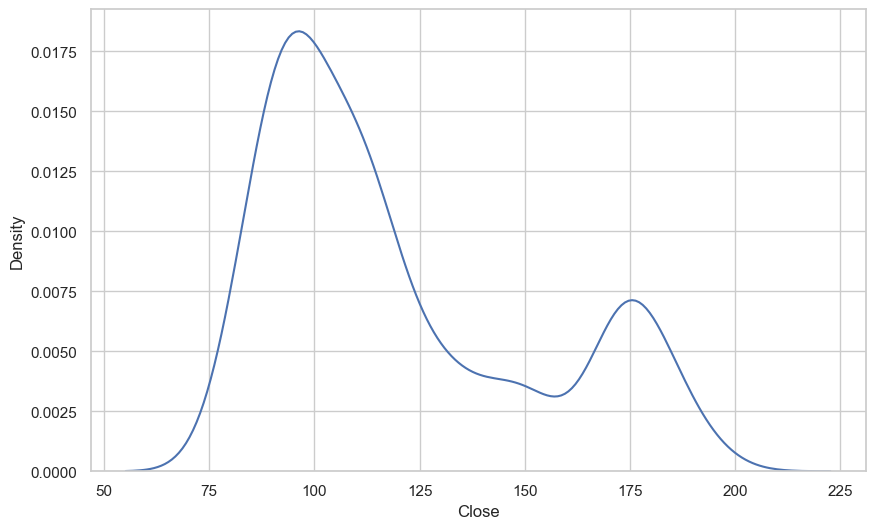

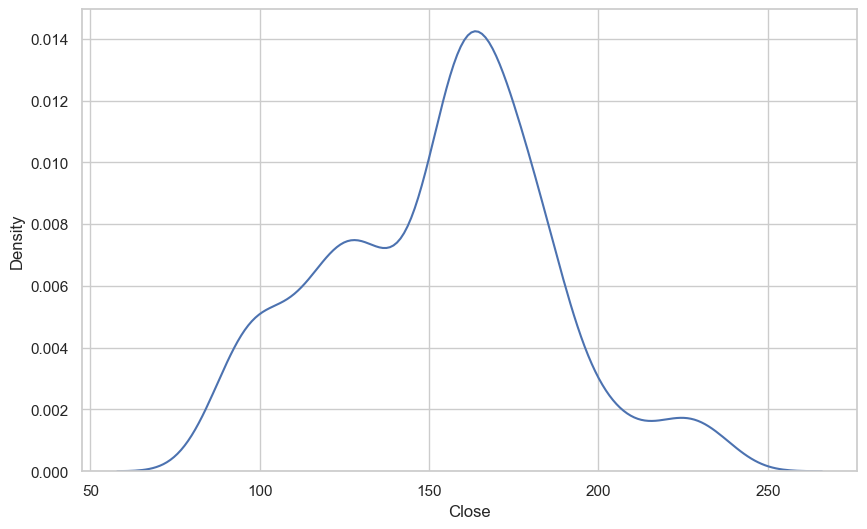

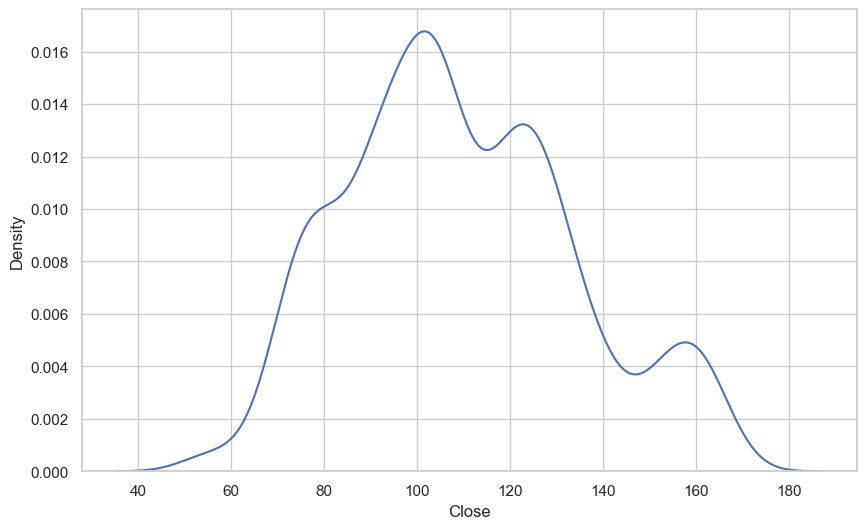

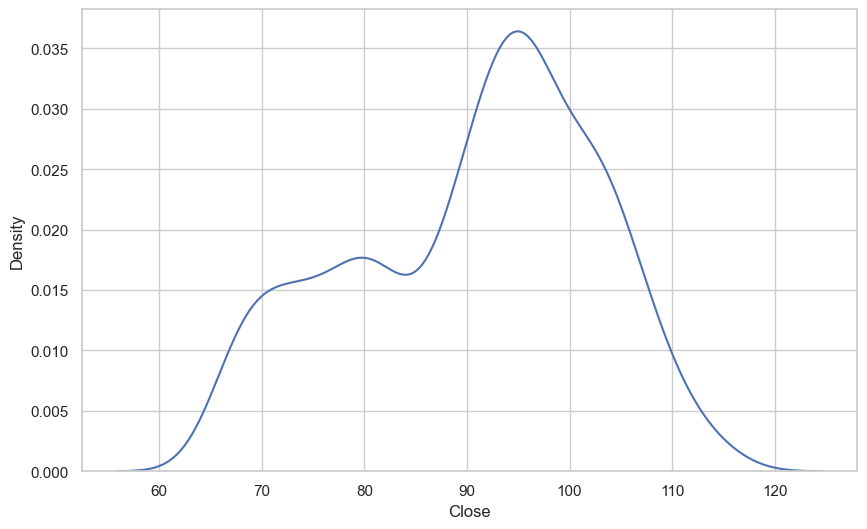

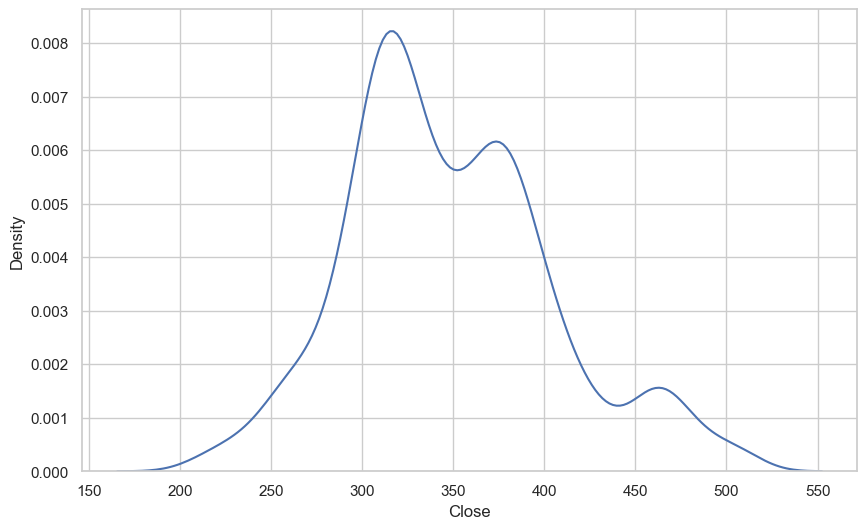

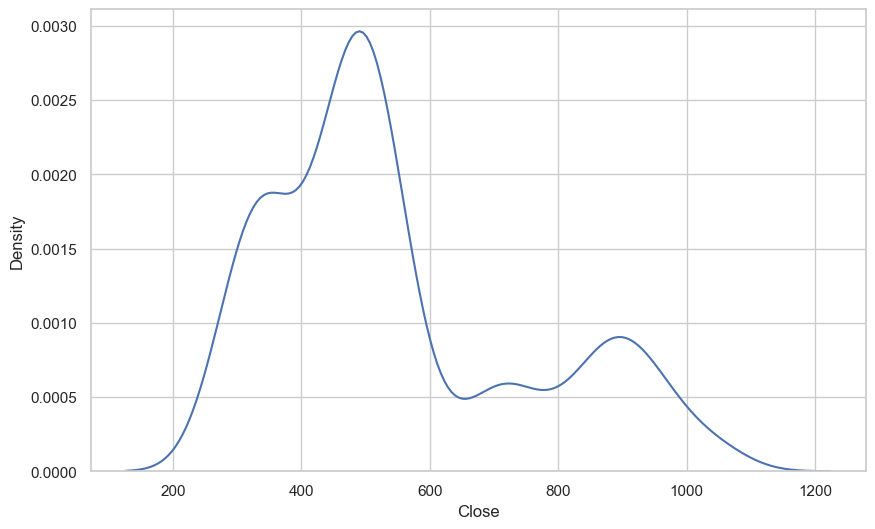

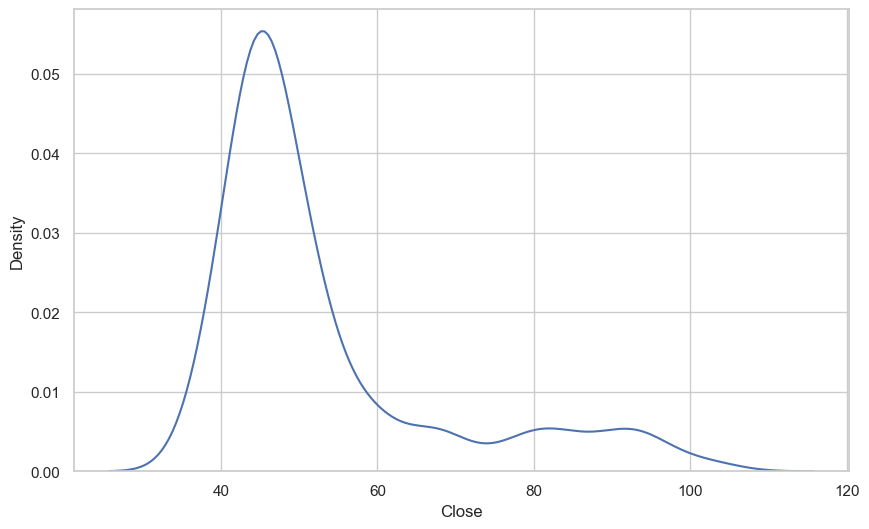

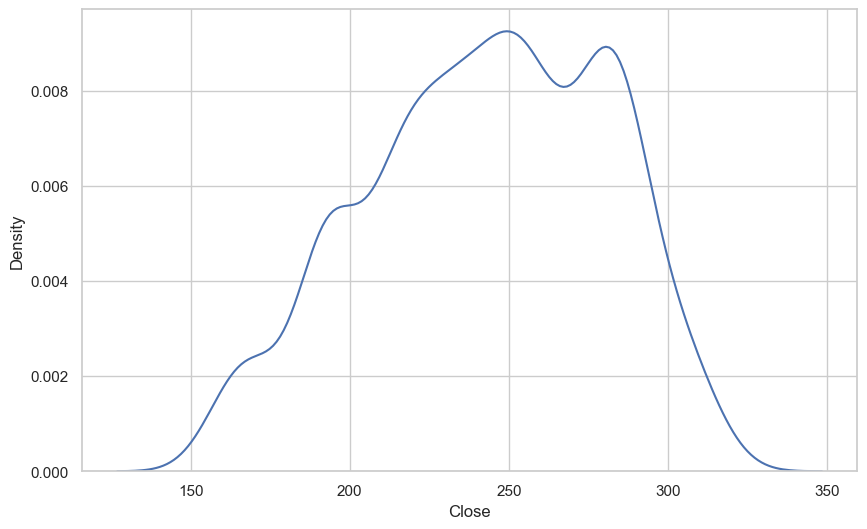

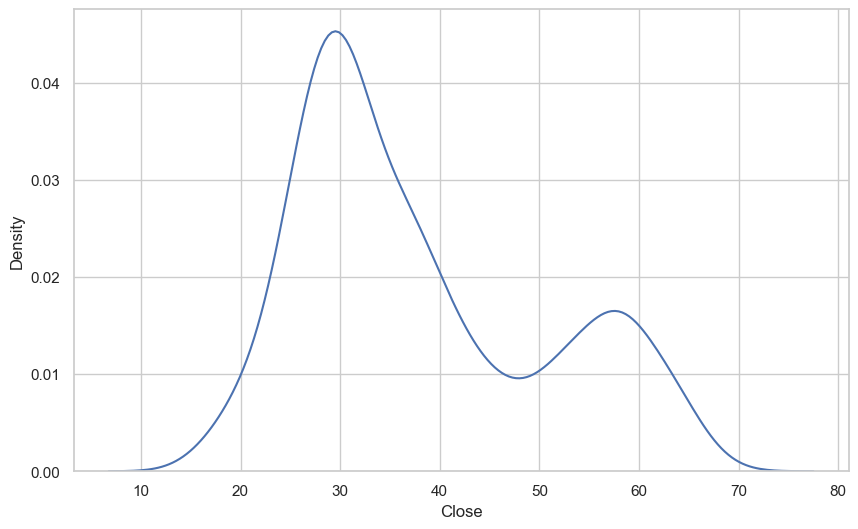

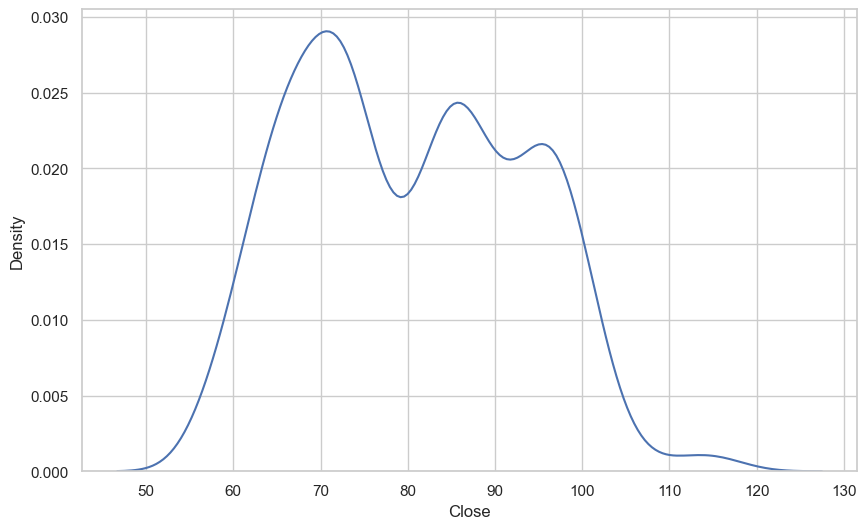

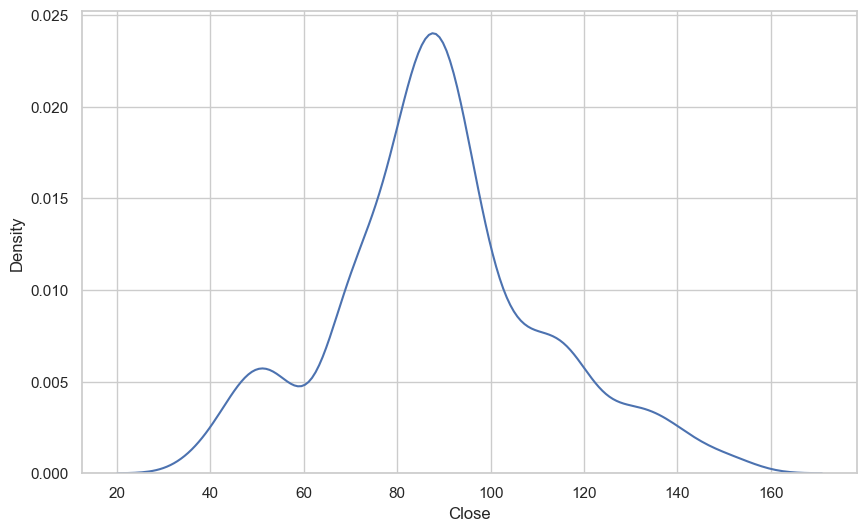

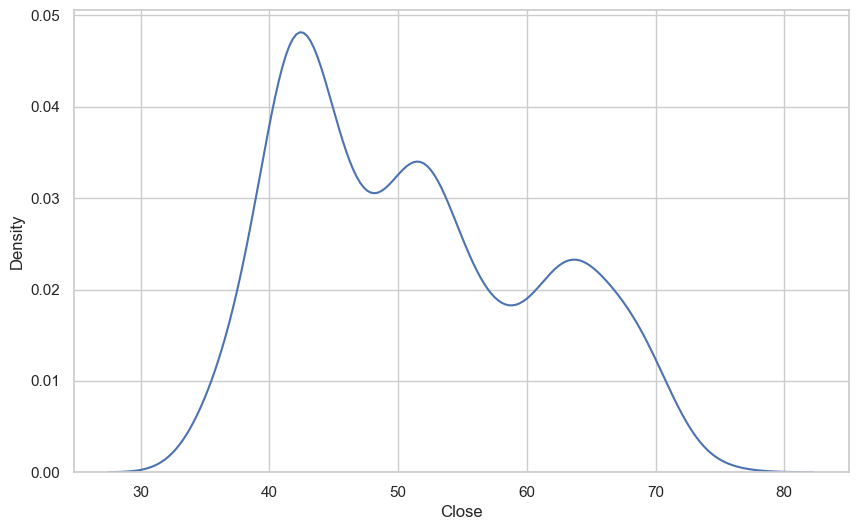

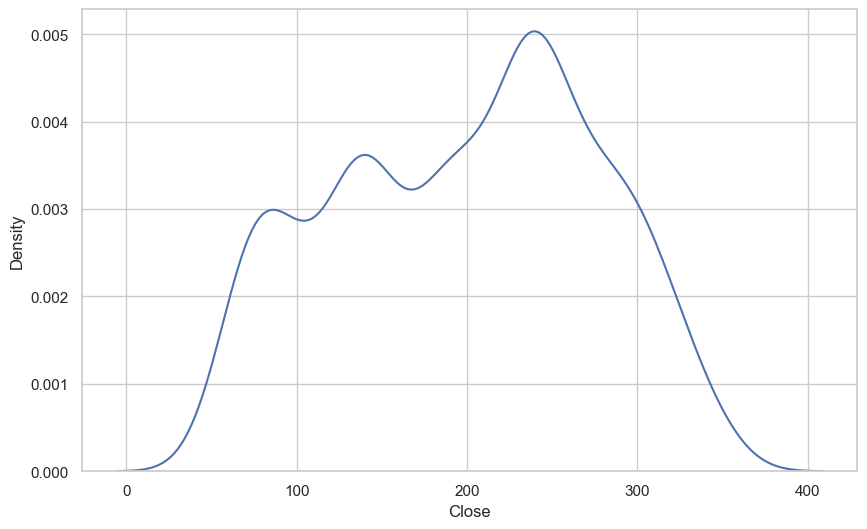

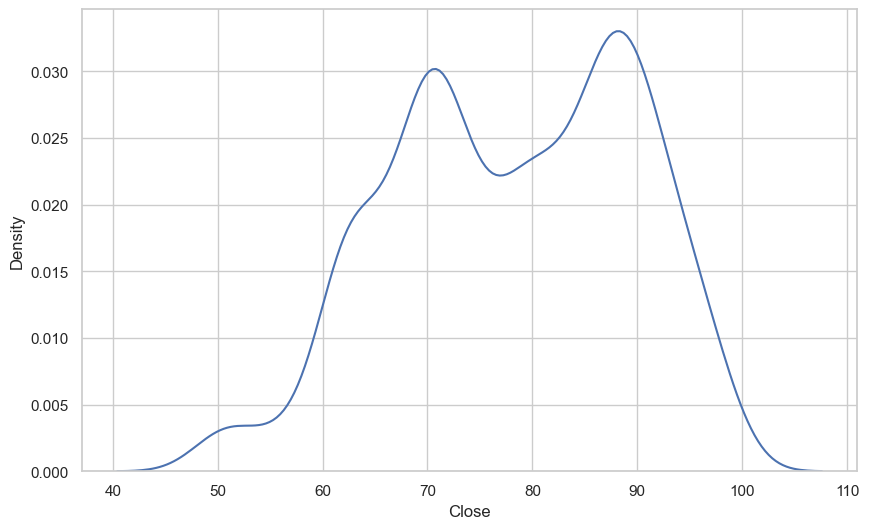

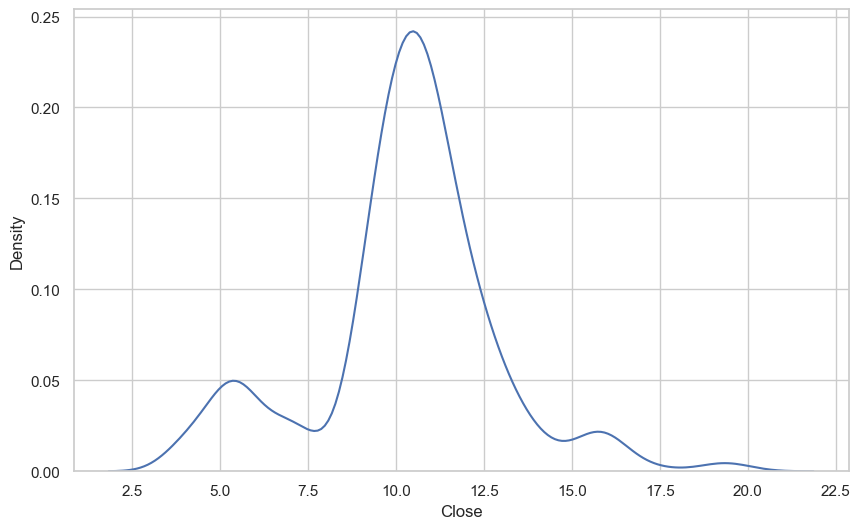

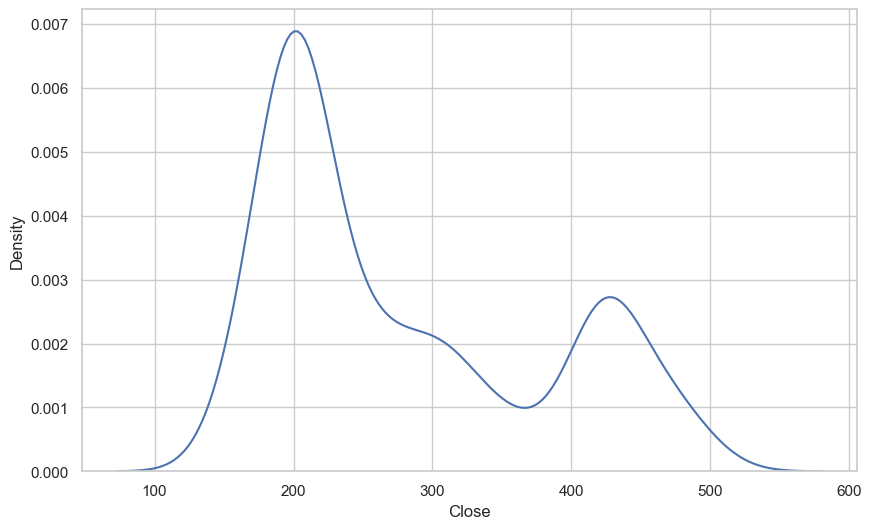

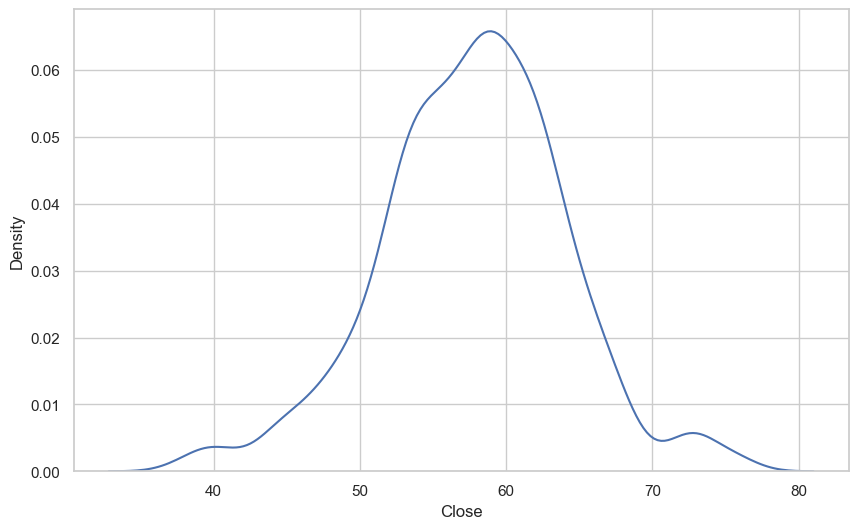

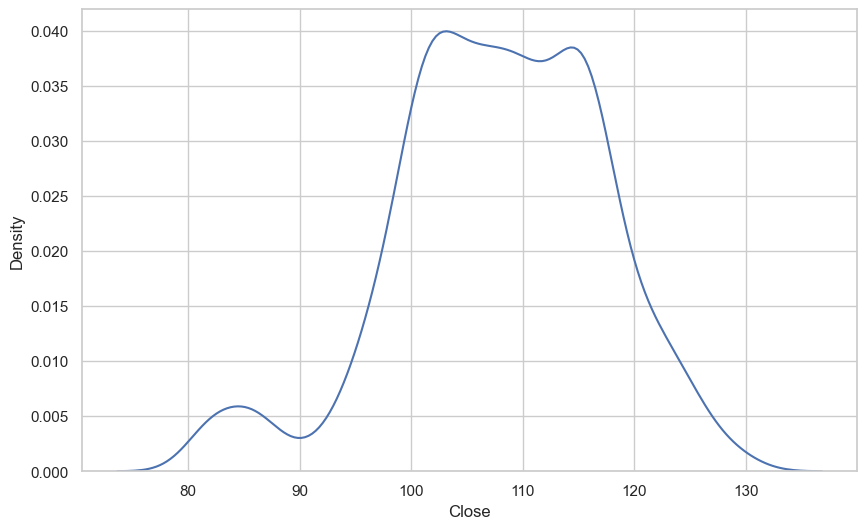

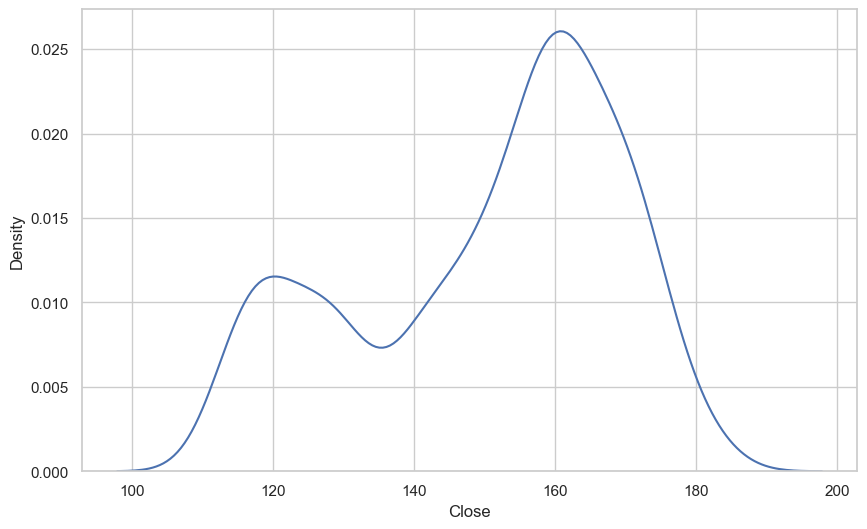

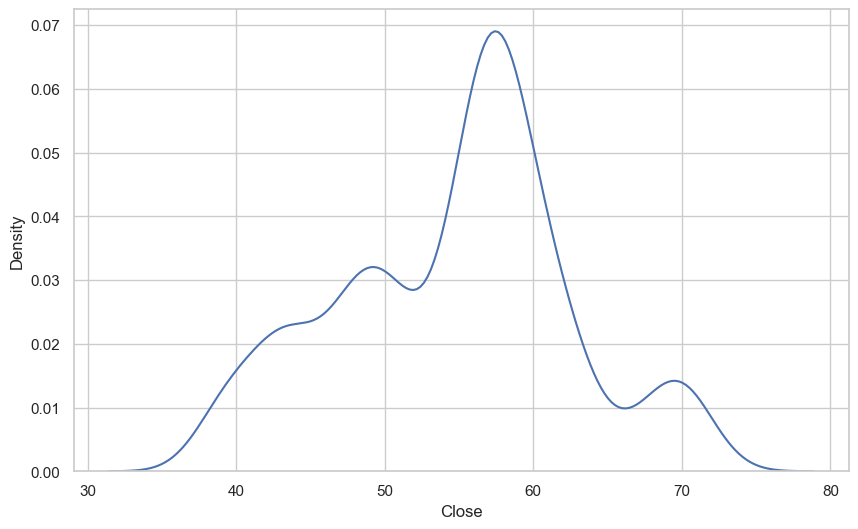

In [40]:
for ticker in tickers:
    sns.kdeplot(consumer_df[consumer_df['Ticker'] == ticker]['Close'])
    plt.show()

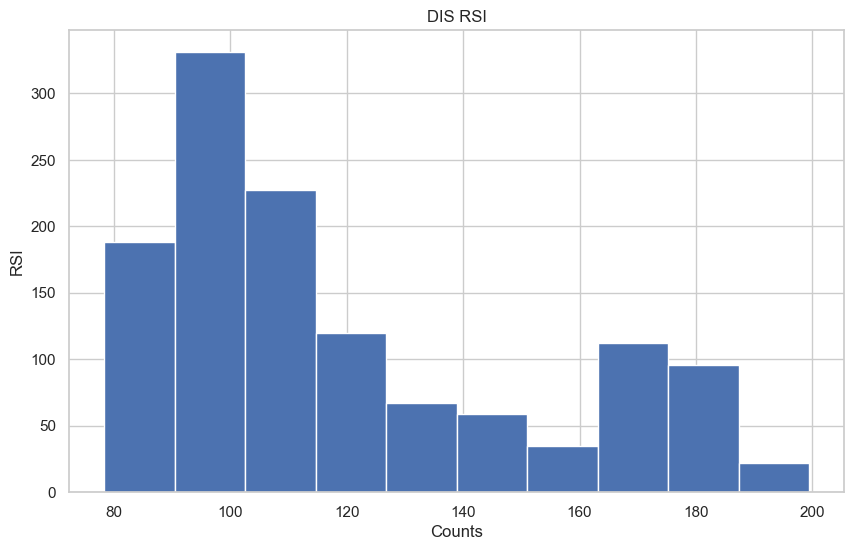

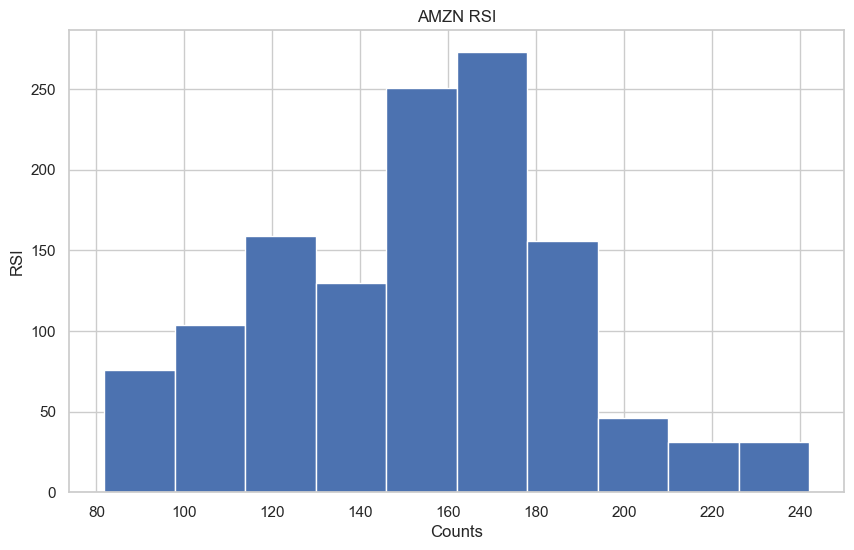

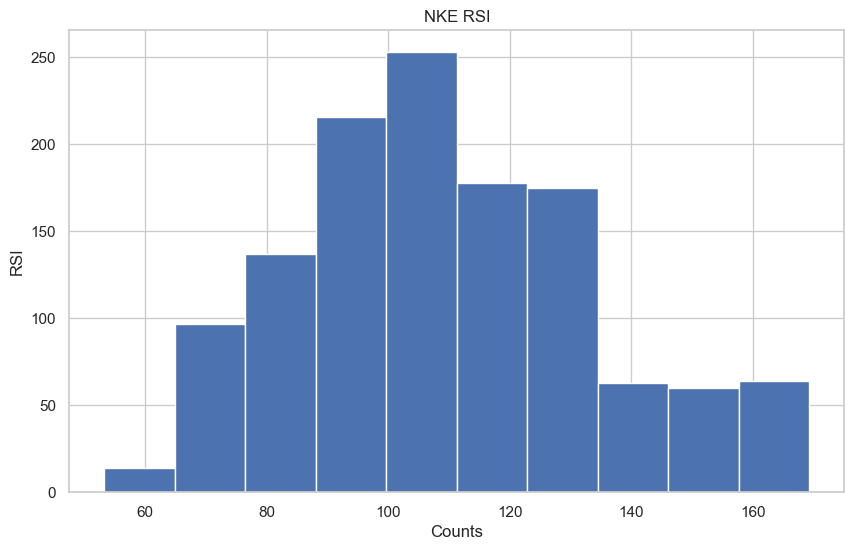

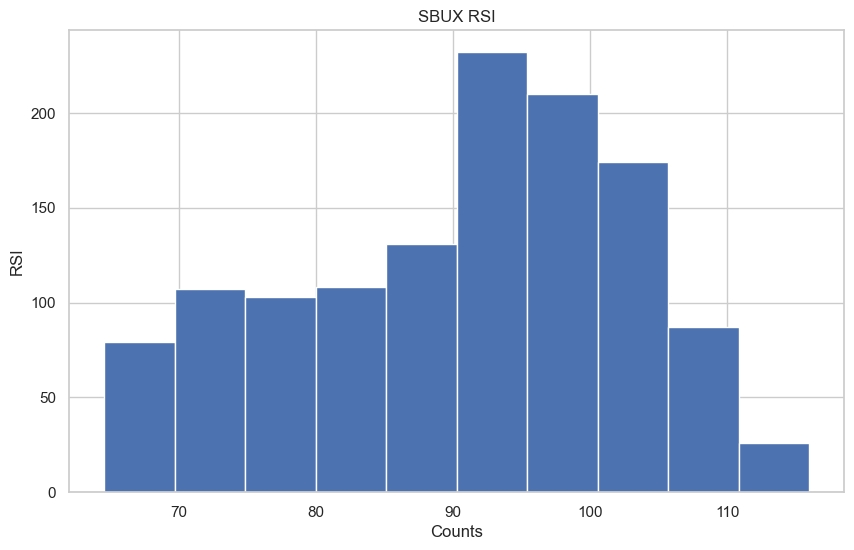

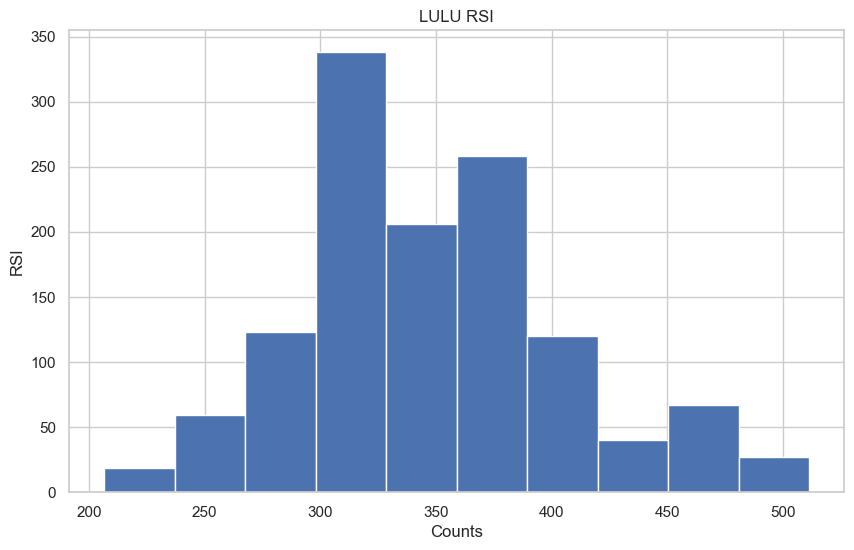

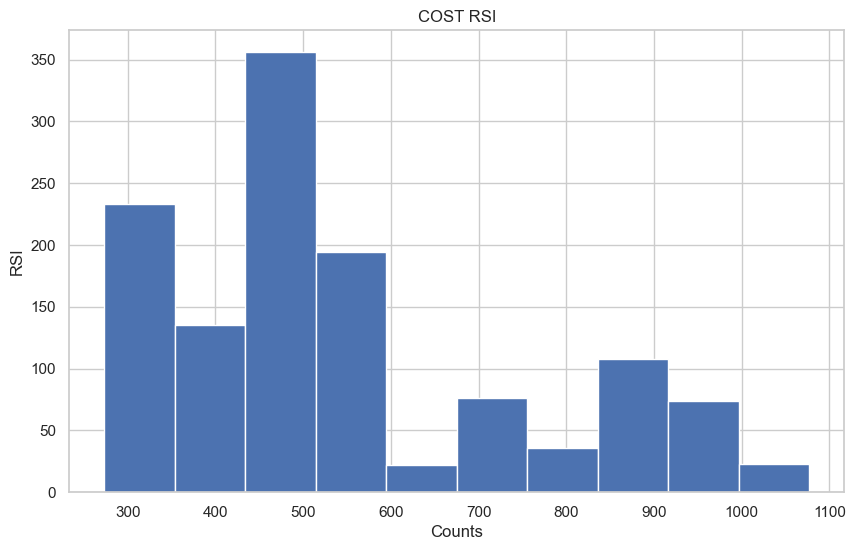

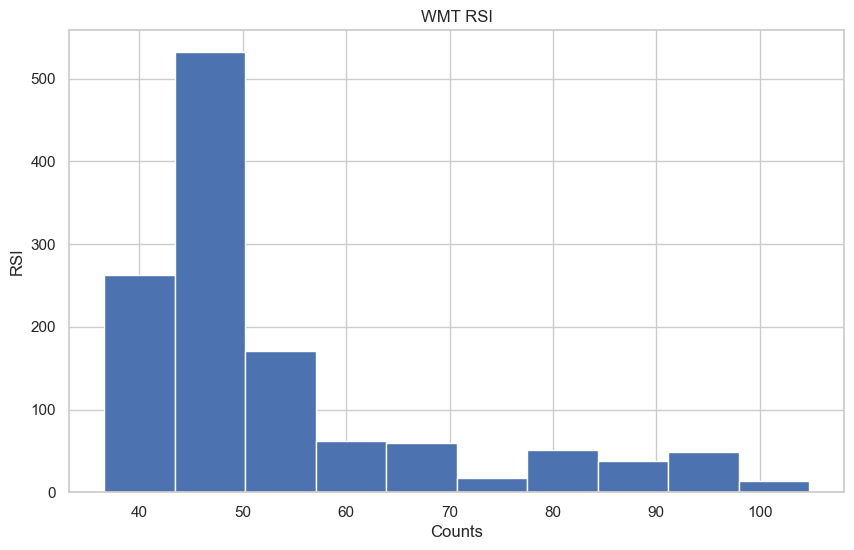

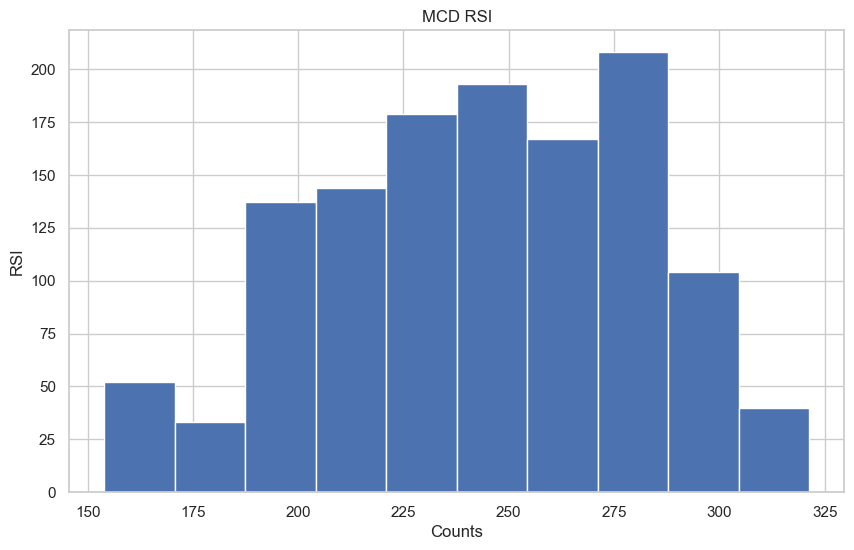

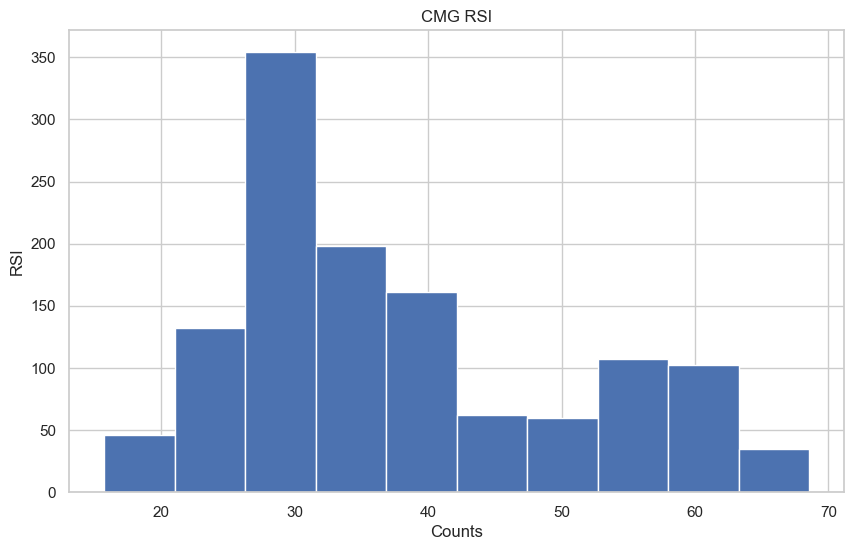

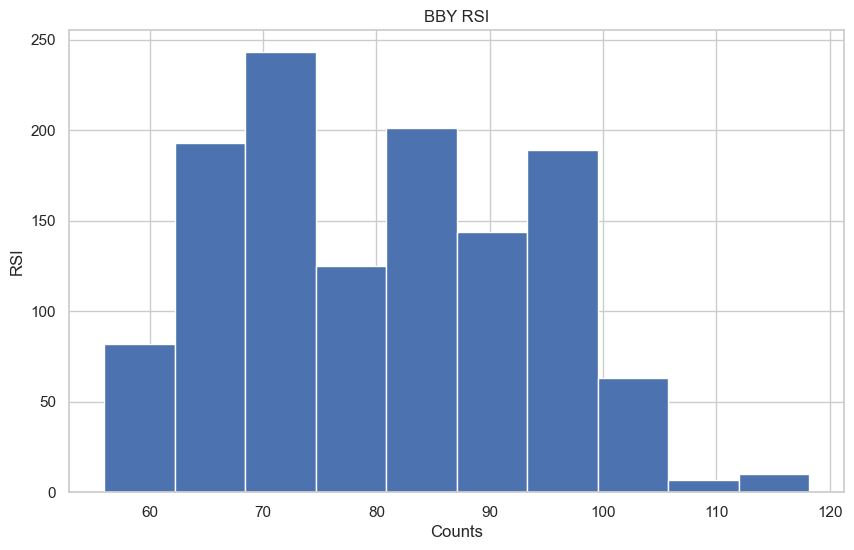

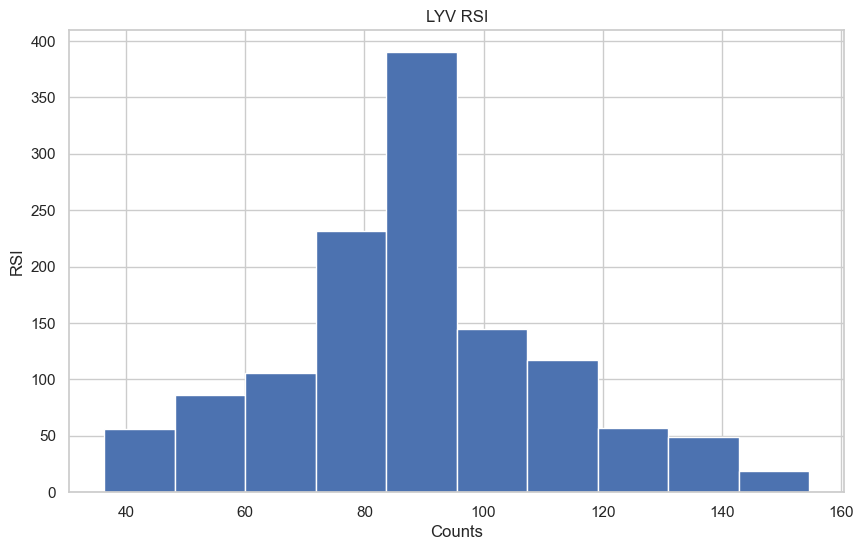

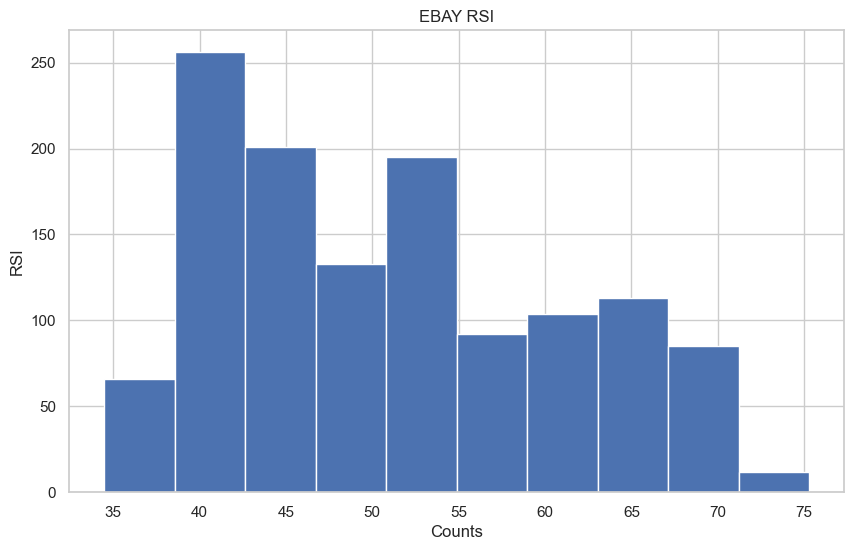

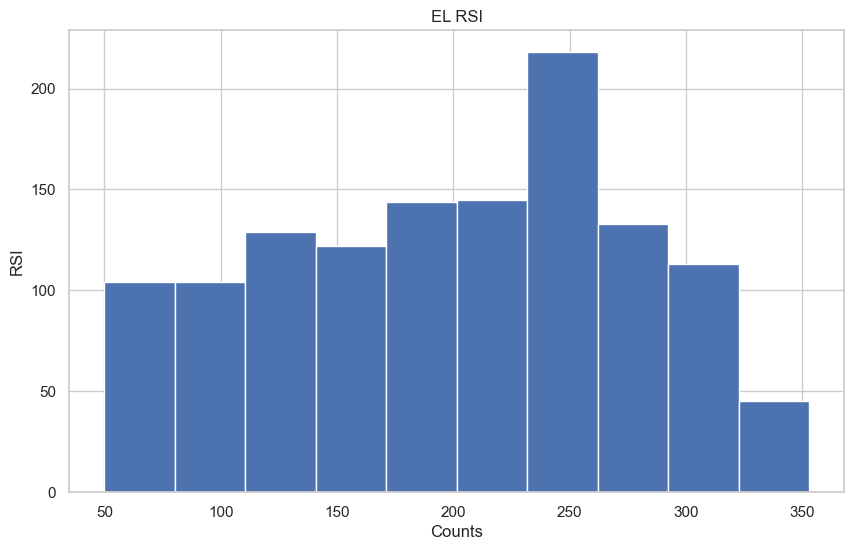

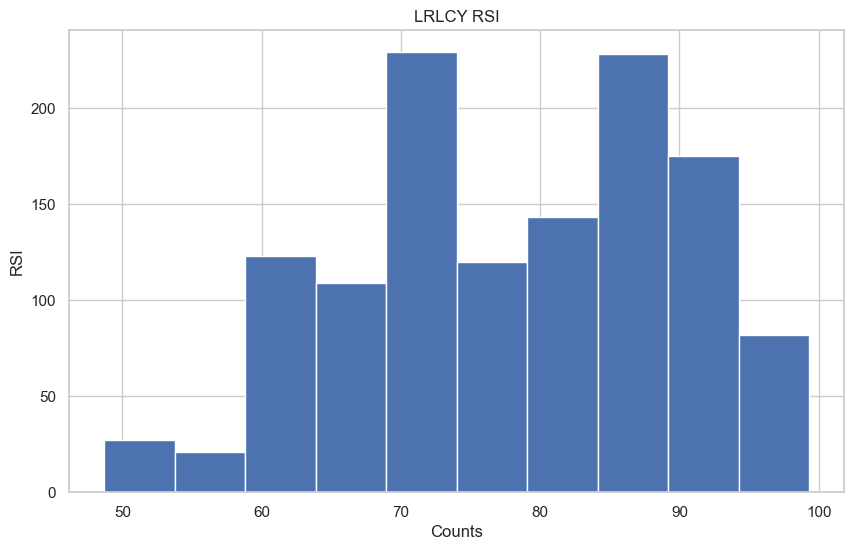

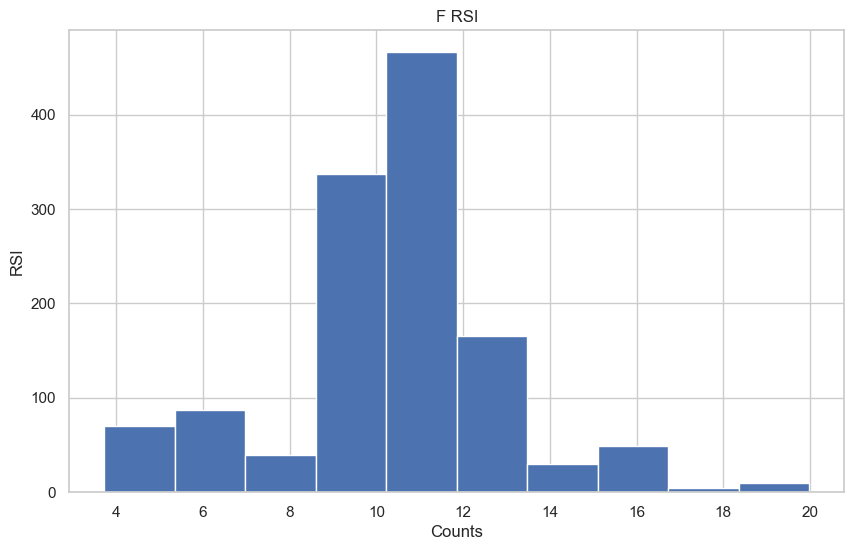

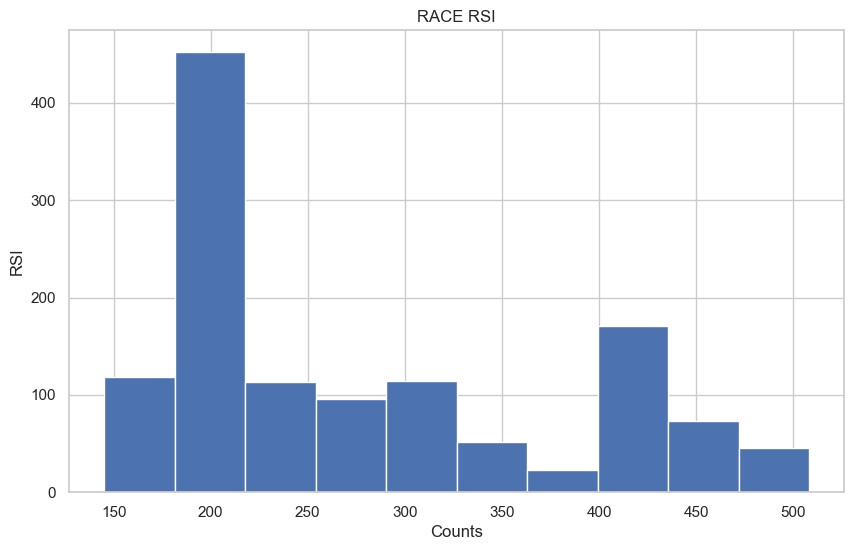

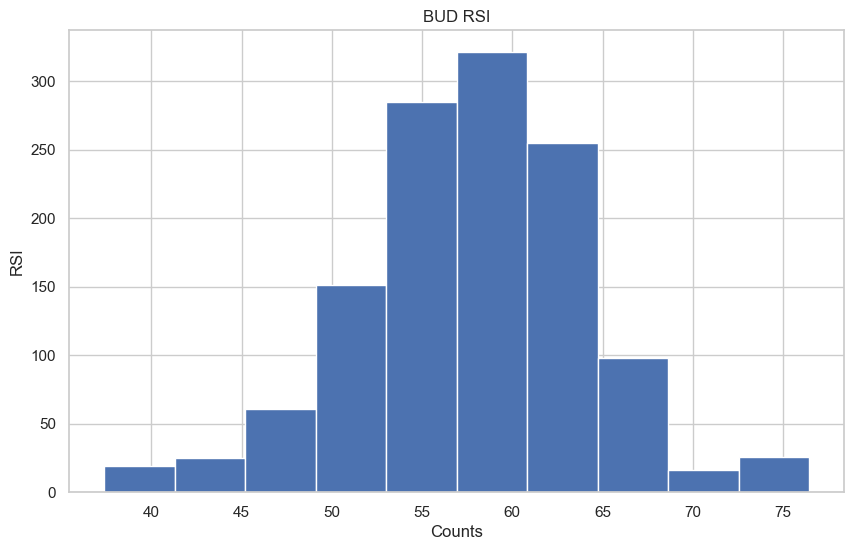

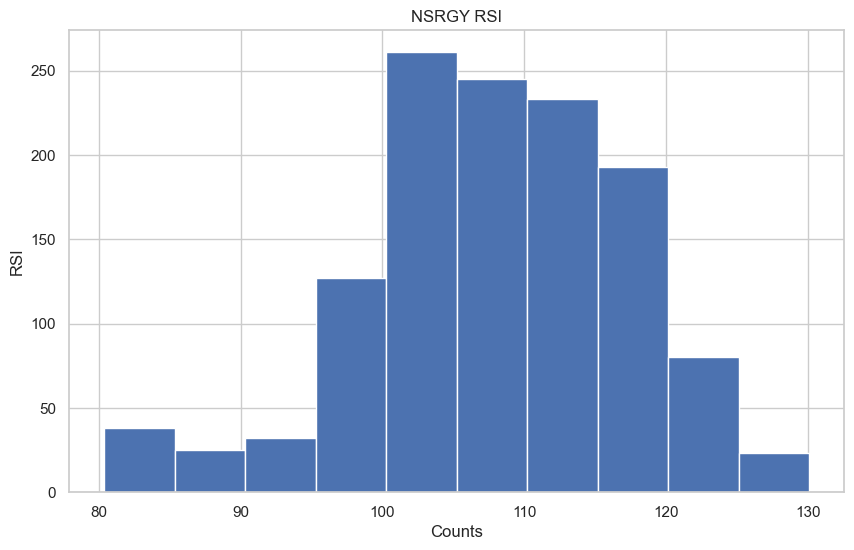

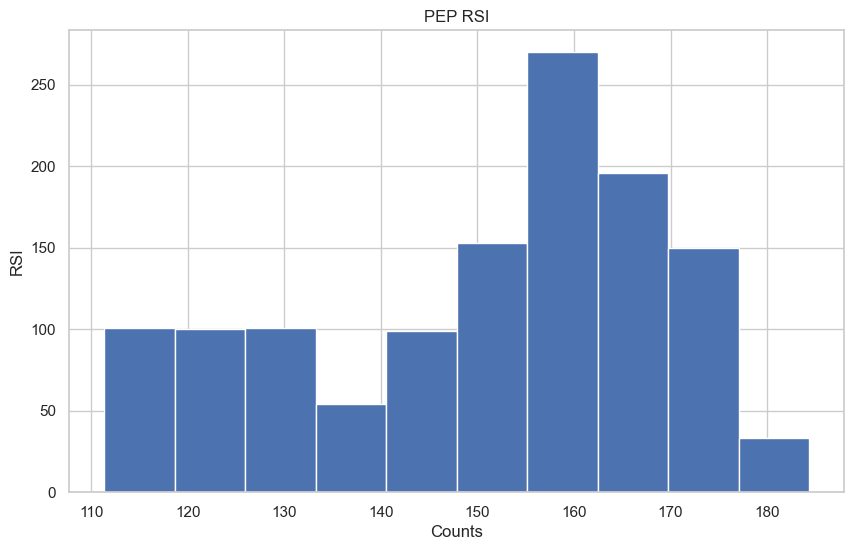

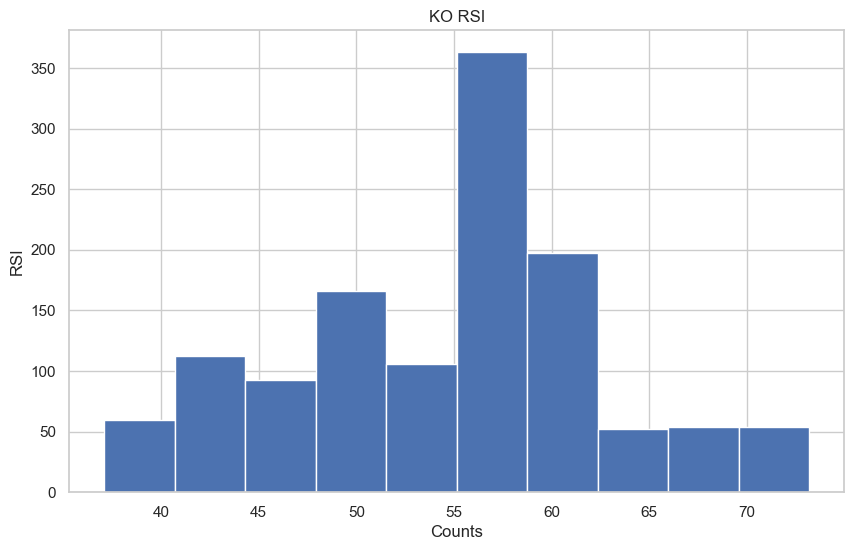

In [64]:
for ticker in tickers:
    arr = consumer_df[consumer_df['Ticker'] == ticker]['Close']
    serie = pd.Series(arr)
    serie.plot.hist()
    plt.title(f"{ticker} RSI")
    plt.xlabel('Counts')
    plt.ylabel('RSI')
    plt.show()

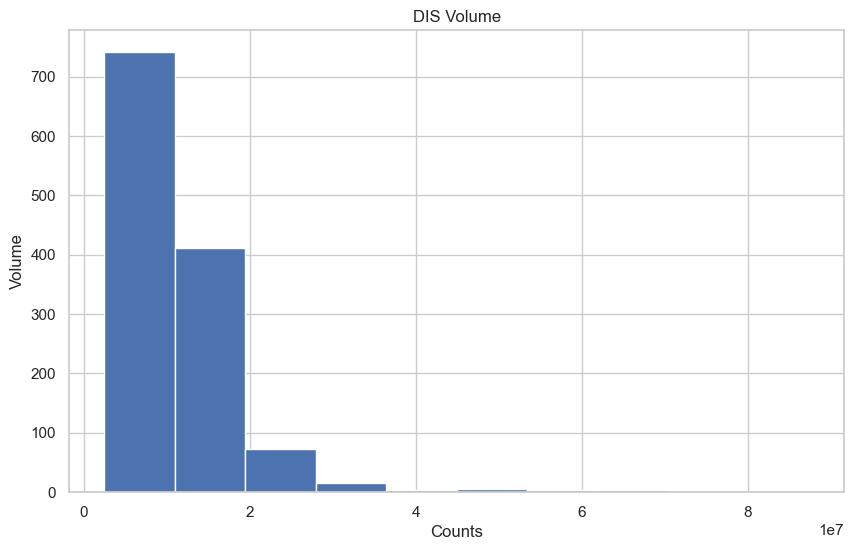

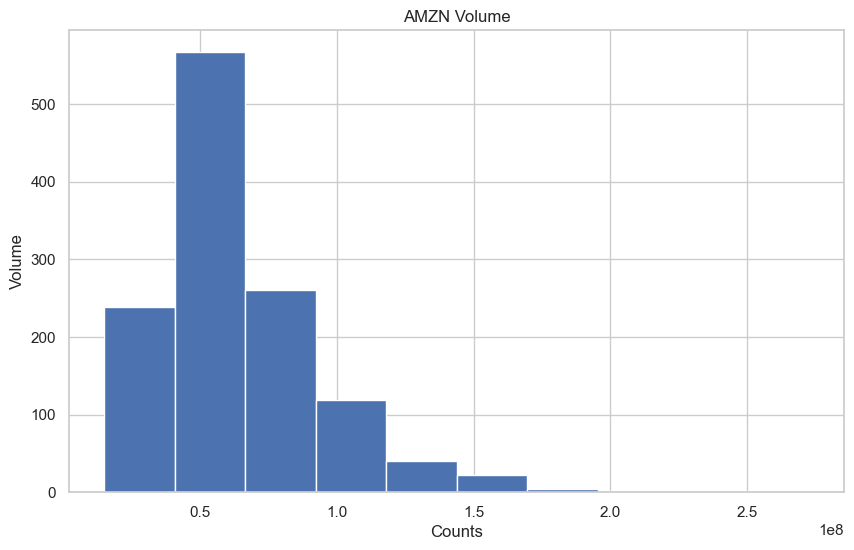

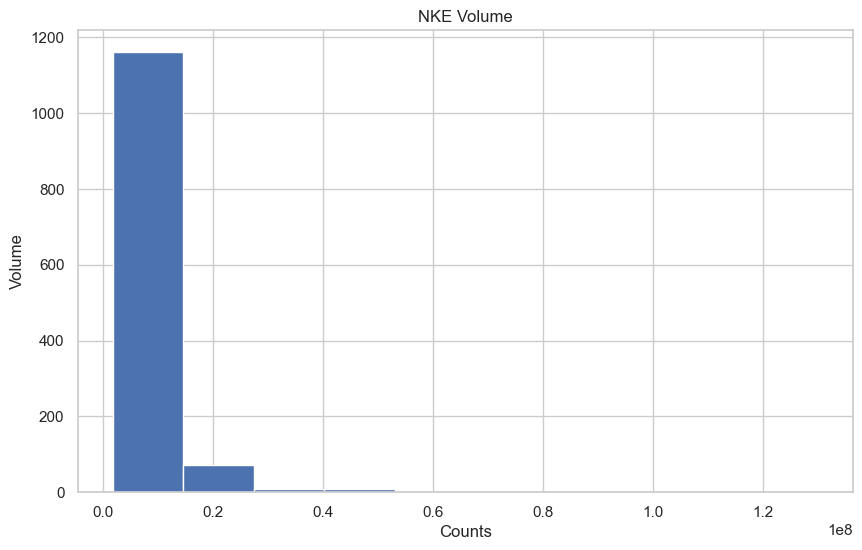

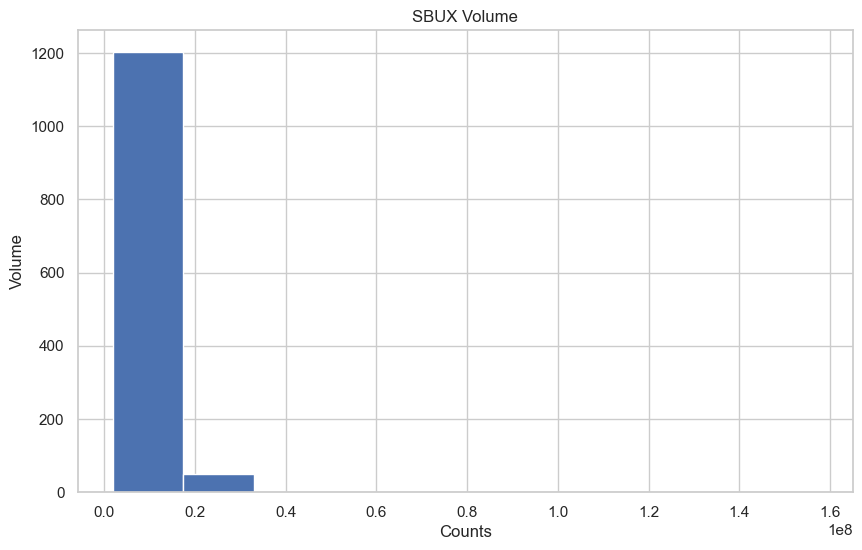

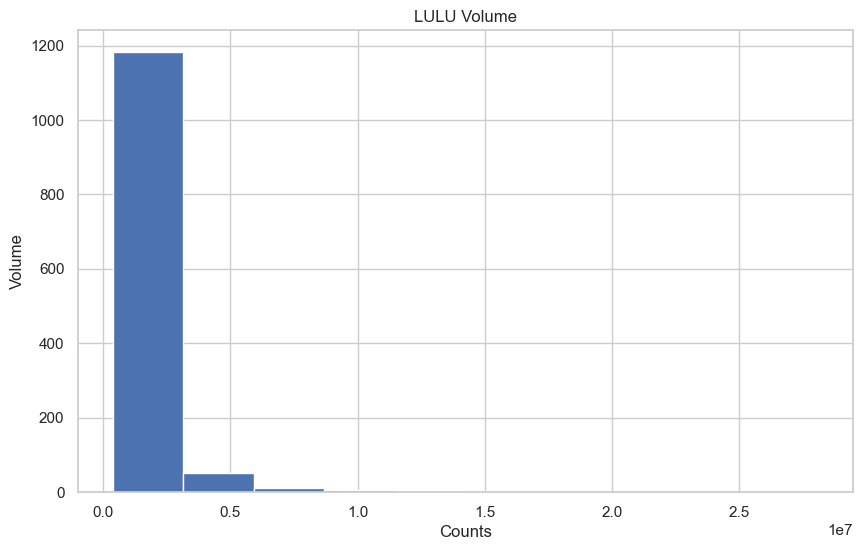

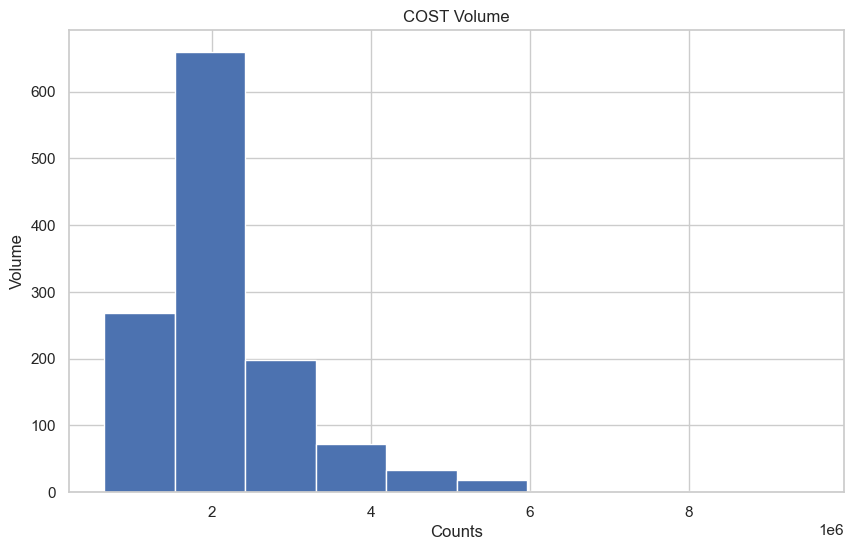

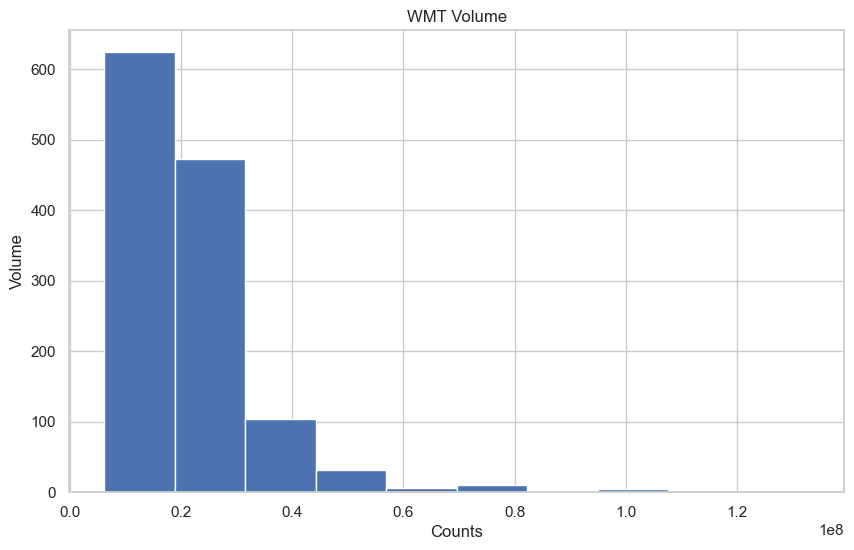

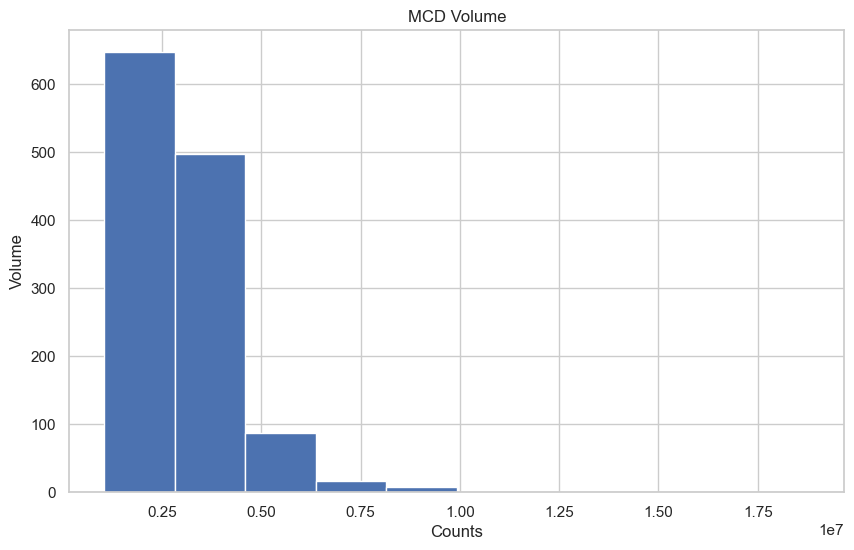

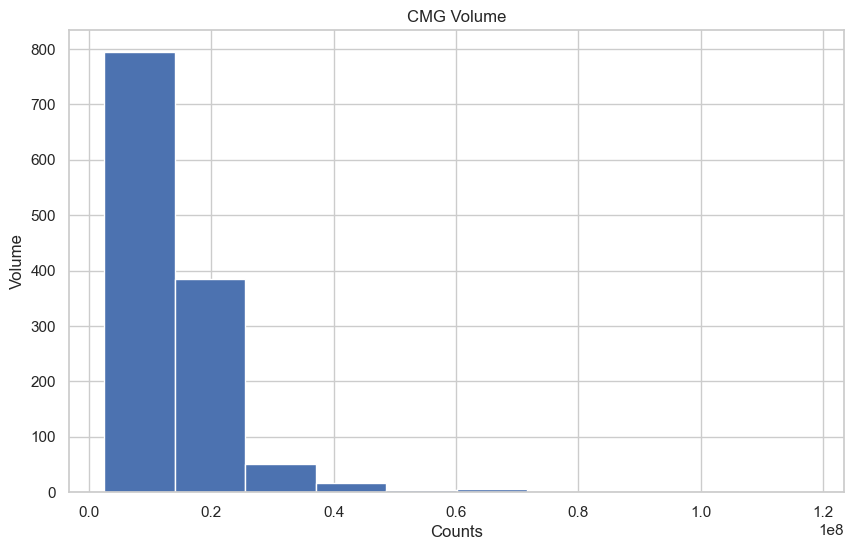

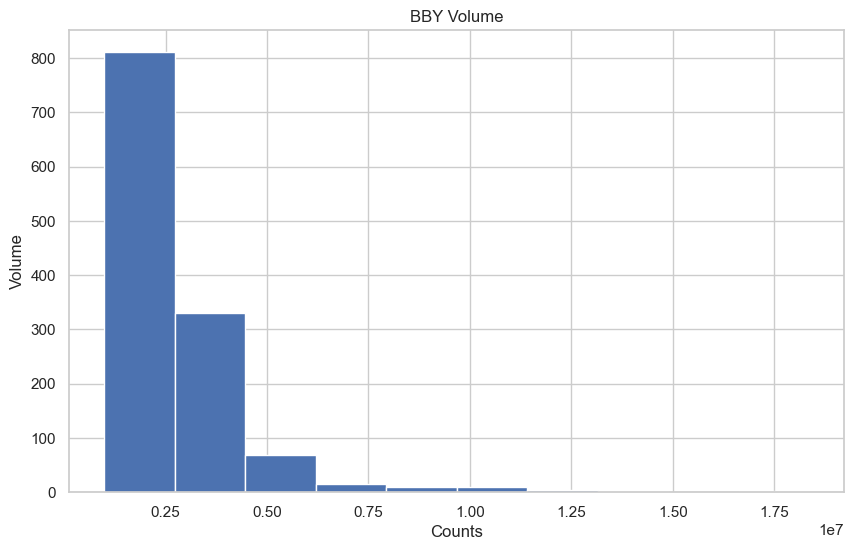

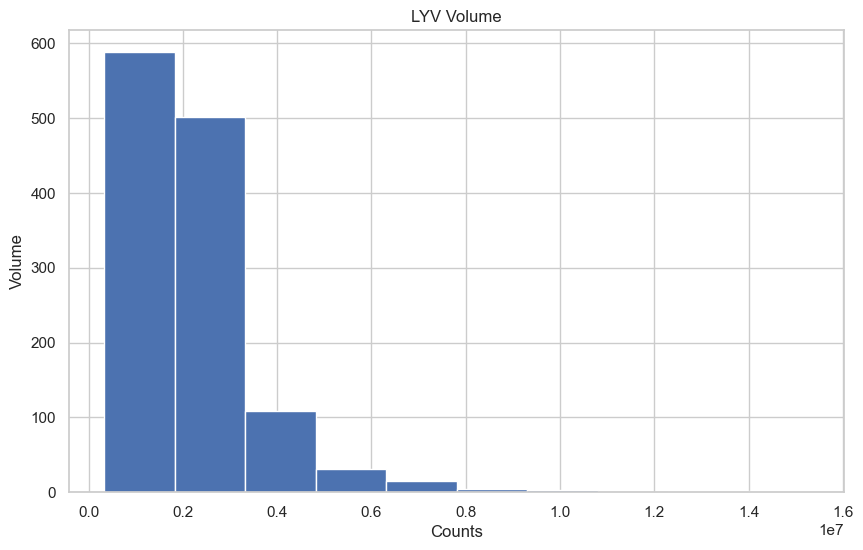

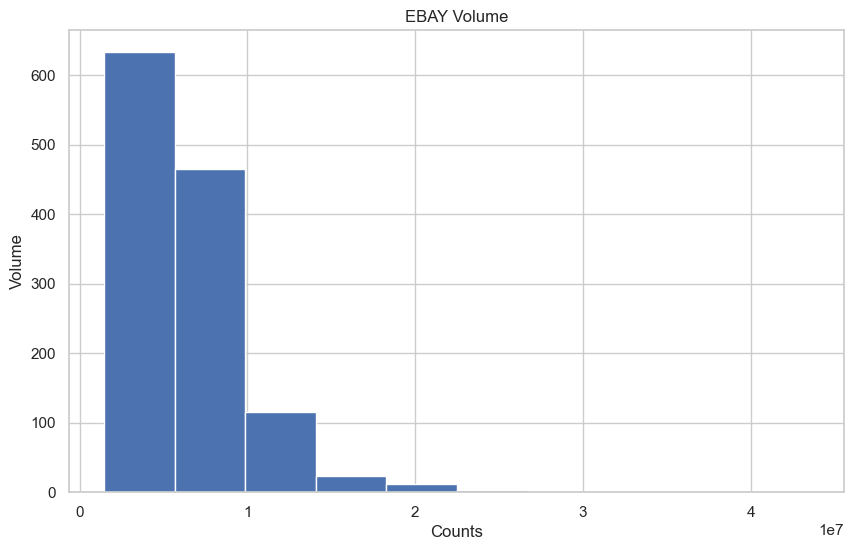

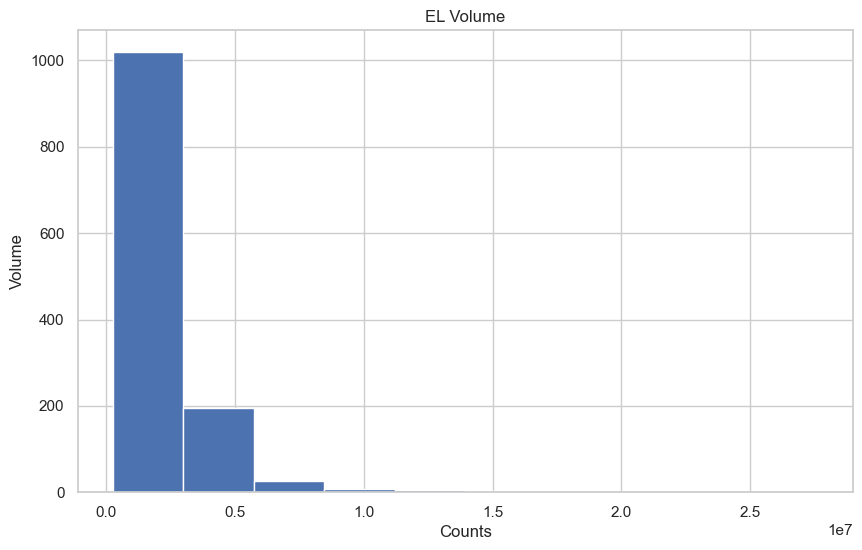

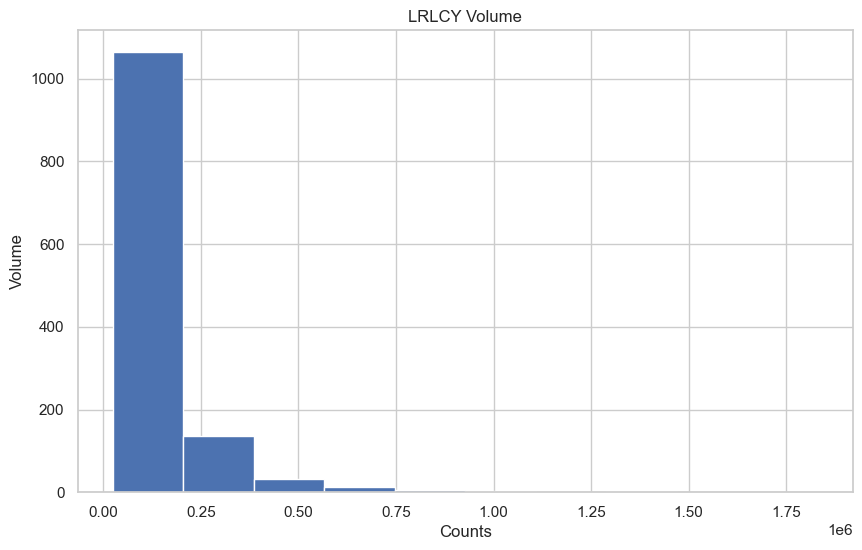

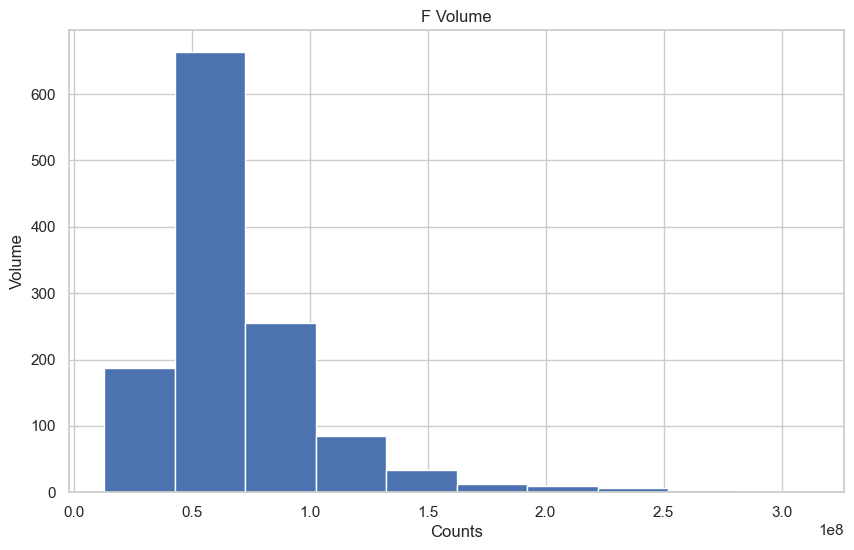

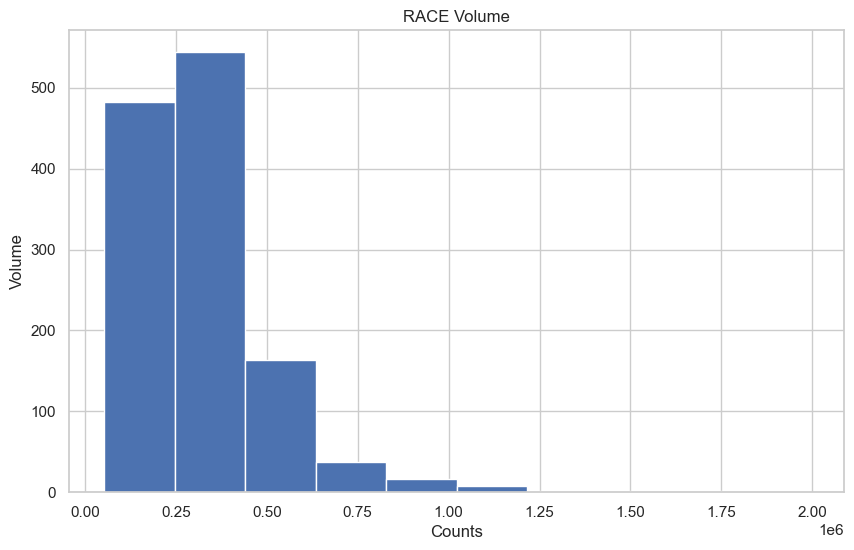

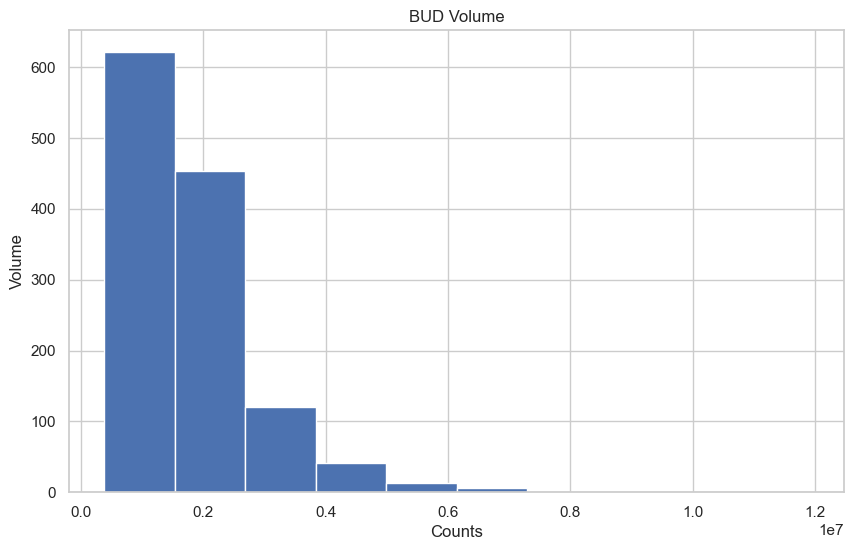

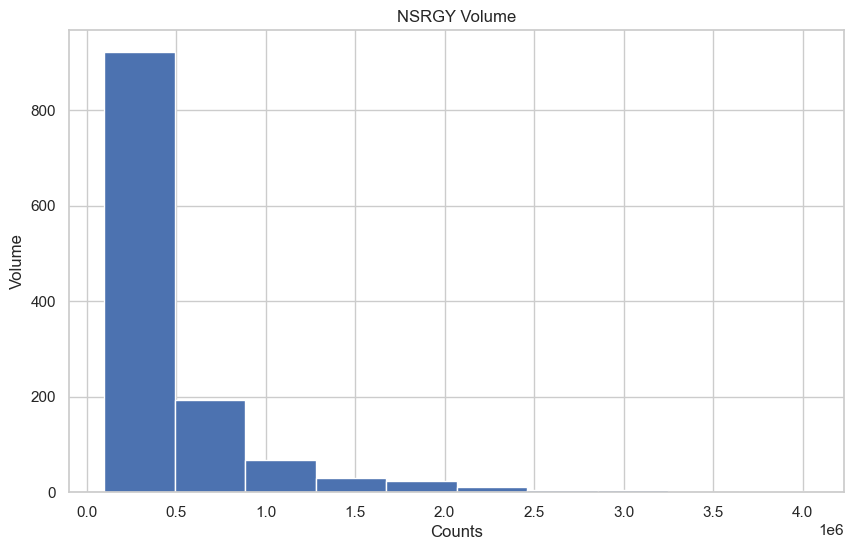

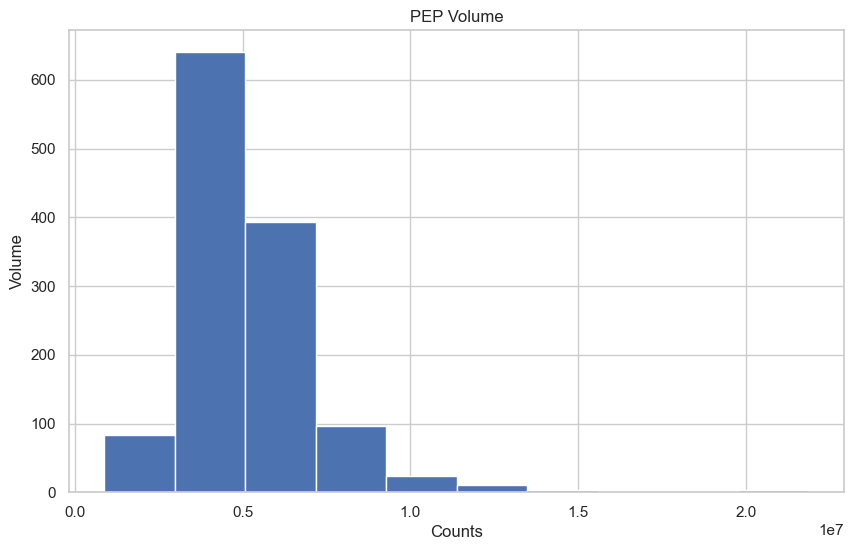

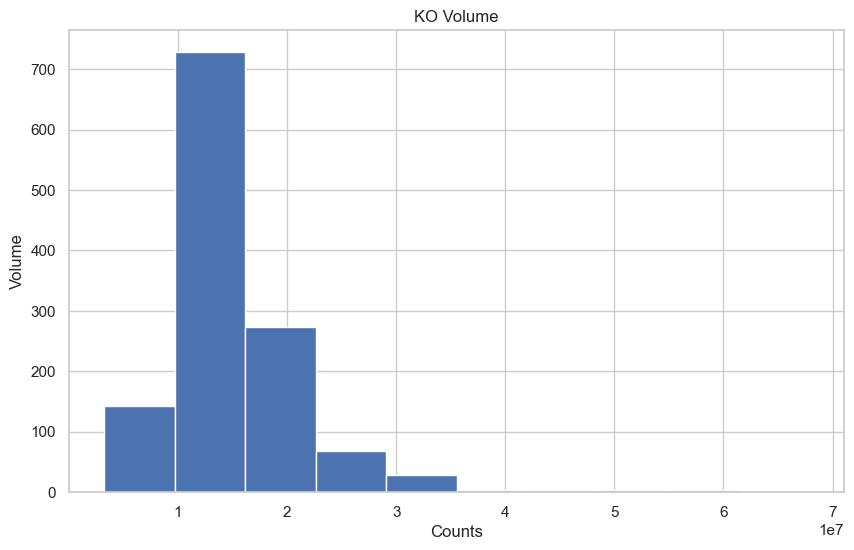

In [66]:
for ticker in tickers:
    arr = consumer_df[consumer_df['Ticker'] == ticker]['Volume']
    serie = pd.Series(arr)
    serie.plot.hist()
    plt.title(f"{ticker} Volume")
    plt.xlabel('Counts')
    plt.ylabel('Volume')
    plt.show()

#### 5) Check the Relationship Between Features and the Target
Explore how technical indicators relate to the target (next day’s close). Use scatter plots or group-by summaries to spot patterns.
- **Resource**: [Scatter plot with a grouping variable with Pandas](https://python-graph-gallery.com/537-scatter-plots-grouped-by-color-with-pandas/)

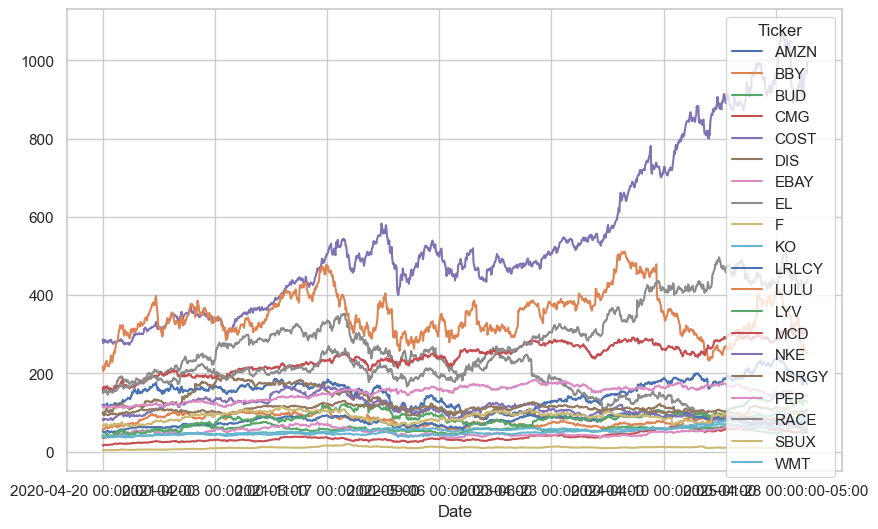

In [68]:
import matplotlib
close_piv = consumer_df.pivot(index='Date', columns='Ticker', values = 'Close')
close_piv.plot()
plt.show()

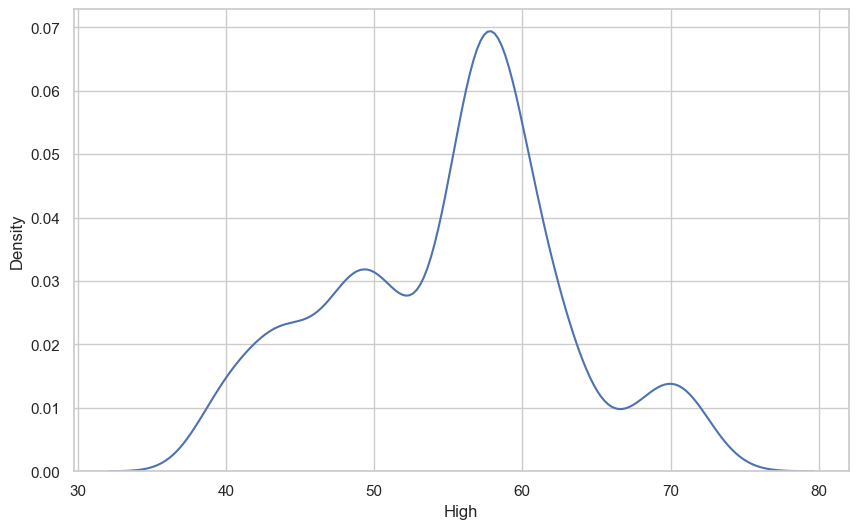

In [70]:
sns.kdeplot(df['High'])
plt.show()

#### 6) Use Boxplots to Detect Outliers
- Boxplots are a great way to spot extreme values or outliers in numeric features. 
- Outliers can influence your model heavily — decide whether to keep, remove, or transform them.
- **Resource**: [How to detect outliers using IQR and Boxplots?](https://www.machinelearningplus.com/machine-learning/how-to-detect-outliers-using-iqr-and-boxplots/)

In [76]:
for column in consumer_df:
    if column in consumer_df.columns[2:]:
        plt.figure()
        plt.gca().set_title(column)
        df.boxplot([column])

KeyError: "None of [Index(['Daily Return'], dtype='object')] are in the [columns]"

#### 7) Investigate Patterns Over Time or Between Groups (Sector, Ticker, etc.)
- Use time-based plots to see if the target or indicators change by day of the week or over time.
- Grouped boxplots can help reveal differences between companies or sectors.
- **Resource**: [Python Plotting for Exploratory Data Analysis](https://pythonplot.com/)

#### 8) Brainstorm & Engineer New Features Based on Your Insights
- Consider creating features like price range, volatility, lagged prices, or differences from moving averages.
- These can help capture patterns not directly visible in raw features.
- **Resource**: [A Reference Guide to Feature Engineering](https://www.kaggle.com/code/prashant111/a-reference-guide-to-feature-engineering-methods)